# Climate Change and Impacts in Africa

Task at hand is to report the state of climate change in Africa using the dataset [IEA-EDGAR CO2 dataset](https://docs.google.com/spreadsheets/d/1cNhVUPKYP79AayGJp89_tXCJmHoxQO4cwiaseSziwbY/edit#gid=191680117).

I will clean, combine and analyze on the state of climate change in Africa and  provide insights on the impact of climate change on African regions (with four countries, one from each African region, as case studies). 

## Dataset

*The dataset, IEA-EDGAR CO2, is a component of the EDGAR (Emissions Database for Global Atmospheric Research) Community GHG database version 7.0 (2022) including or based on data from IEA (2021) Greenhouse Gas Emissions from Energy, www.iea.org/statistics, as modified by the Joint Research Centre. The data source was the [EDGARv7.0_GHG website](https://edgar.jrc.ec.europa.eu/dataset_ghg70) provided by Crippa *et. al.* (2022) and with [DOI](https://data.europa.eu/doi/10.2904/JRC_DATASET_EDGAR).*

The dataset contains three sheets - `IPCC 2006`, `1PCC 1996`, and `TOTALS BY COUNTRY` on the amount of CO2 (a greenhouse gas) generated by countries between 1970 and 2021. 

### TOTALS BY COUNTRY SHEET

This sheet contains the annual CO2 (kt) produced between 1970 - 2021 in each country. The relevant columns in this sheet are:

| Columns | Description |
| ------- | ------------|
| `C_group_IM24_sh` | The region of the world |
| `Country_code_A3` | The country code |
| `Name`            | The name of the country |
| `Y_1970 - Y_2021` | The amount of CO2 (kt) from 1970 - 2021 |


### IPCC 2006

These sheets contain the amount of CO2 by country and the industry responsible. 

| Columns | Description |
| ------- | ------------|
| `C_group_IM24_sh` | The region of the world |
| `Country_code_A3` | The country code |
| `Name`            | The name of the country |
| `Y_1970 - Y_2021` | The amount of CO2 (kt) from 1970 - 2021 |
| `ipcc_code_2006_for_standard_report_name` | The industry responsible for generating CO2 |

In [48]:
# Setup
import pandas as pd
import numpy as np
import pingouin
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import OLS
import seaborn as sns
import matplotlib.pyplot as plt
import inspect

plt.style.use('ggplot')
# The sheet names containing our datasets
sheet_names = ['IPCC 2006', 'TOTALS BY COUNTRY']

# The column names of the dataset starts from rows 11
# Let's skip the first 10 rows
datasets = pd.read_excel('IEA_EDGAR_CO2_1970-2021.xlsx', sheet_name = sheet_names, skiprows = 10)

# we need only the African regions
african_regions = ['Eastern_Africa', 'Western_Africa', 'Southern_Africa', 'Northern_Africa']

ipcc_2006_africa = datasets['IPCC 2006'].query('C_group_IM24_sh in @african_regions')

totals_by_country_africa = datasets['TOTALS BY COUNTRY'].query('C_group_IM24_sh in @african_regions')


# Read the temperatures datasets containing four African countries
# One from each African Region:
# Nigeria:    West Africa
# Ethiopa :   East Africa
# Tunisia:    North Africa
# Mozambique: South Africa
temperatures = pd.read_csv('temperatures.csv')

## Clean and tidy the datasets

- Renaming a few columns in the corresponding African datasets.
- Dropping unnecessary columns from the corresponding datasets.
- Dropping rows where `CO2` is missing.



In [49]:
# renaming our columns
ipcc_2006_africa=ipcc_2006_africa.rename(columns= {'C_group_IM24_sh': 'Region',
                                 'Country_code_A3': 'Code',
                                 'ipcc_code_2006_for_standard_report_name': 'Industry'})
totals_by_country_africa=totals_by_country_africa.rename(columns= {'C_group_IM24_sh': 'Region',
                                 'Country_code_A3': 'Code',
                                 'ipcc_code_2006_for_standard_report_name': 'Industry'})


In [50]:
# dropping columns we don't need
ipcc_2006_africa = ipcc_2006_africa.drop(['IPCC_annex','ipcc_code_2006_for_standard_report','Substance'], axis=1)
totals_by_country_africa=totals_by_country_africa.drop(['IPCC_annex','Substance'], axis=1)
ipcc_2006_africa.columns
#melting columns 
ipcc_2006_africa=ipcc_2006_africa.melt(id_vars=['Region', 'Code', 'Name',
                               'Industry','fossil_bio'],
                      value_vars=list(filter(lambda x: x.startswith('Y_'), ipcc_2006_africa.columns)),
                      var_name='Year',
                      value_name='CO2'
                     )
totals_by_country_africa=totals_by_country_africa.melt(id_vars=['Region', 'Code', 'Name'],
                                                      value_vars=list(filter(lambda x: x.startswith('Y_'),totals_by_country_africa.columns)),
                                                      var_name='Year',
                                                      value_name='CO2')

                                                        


In [51]:
 
#dropping rows where CO2 is null
ipcc_2006_africa = ipcc_2006_africa.dropna(axis=0, subset=['CO2'])
totals_by_country_africa = totals_by_country_africa.dropna(axis=0, subset=['CO2'])

#converting year  into int type
ipcc_2006_africa.Year=ipcc_2006_africa.Year.str.replace('Y_', '').astype(int)
totals_by_country_africa.Year=totals_by_country_africa.Year.str.replace('Y_', '').astype(int)



## Showing the trend of `CO2` levels across the African regions


- Using `totals_by_country_africa`to create a line plot of `CO2` vs. `Year` in each `Region` to show the trend of CO2 levels by year.


![co2_vs_year](co2_year.png)

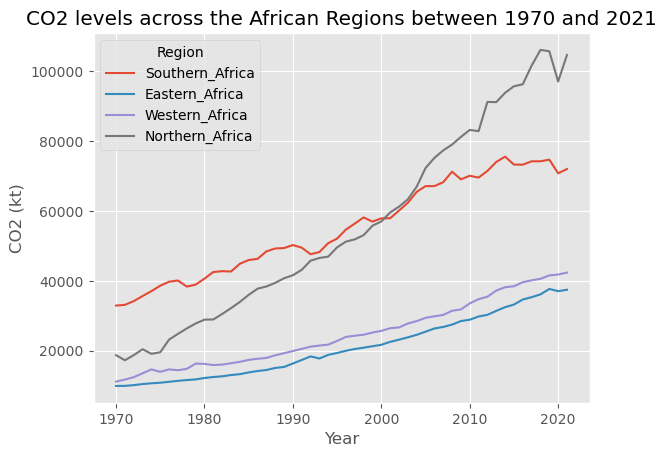

In [52]:
# trend of CO2 levels using a lineplot
sns.lineplot(data=totals_by_country_africa, x='Year', y='CO2',hue='Region',errorbar=None)
# adding the x label and title 
plt.title("CO2 levels across the African Regions between 1970 and 2021")
plt.ylabel("CO2 (kt)")
plt.show()

## Determining the relationship between time (`Year`) and `CO2` levels across the African regions

- Using the `totals_by_country_africa` dataset to conduct a Spearman's correlation to determine the relationship between time (`Year`) and `CO2` within each African `Region`.


In [53]:
# conducting Spearman's correlation

relationship_btw_time_CO2 = totals_by_country_africa.groupby('Region')[['Year', 'CO2']].corr(method='spearman')
    
relationship_btw_time_CO2 


Year       CO2
Region                                  
Eastern_Africa  Year  1.000000  0.181768
                CO2   0.181768  1.000000
Northern_Africa Year  1.000000  0.429875
                CO2   0.429875  1.000000
Southern_Africa Year  1.000000  0.260986
                CO2   0.260986  1.000000
Western_Africa  Year  1.000000  0.324071
                CO2   0.324071  1.000000

## Is there a significant difference in the CO2 levels among the African Regions?


- Using `totals_by_country_africa`to conduct an ANOVA using `pingouin.anova()` on the `CO2` by `Region`
- Conducting a posthoc test (with Bonferroni correction) using `pingouin.pairwise_tests()` to find the source of the significant difference. 


In [54]:
#conducting the ANOVA test 
aov_results=pingouin.anova(data=totals_by_country_africa,
              dv='CO2',
              between='Region')
# conducting a posthoc test 
pw_ttest_result=pingouin.pairwise_tests(data=totals_by_country_africa,
                                       dv='CO2',
                                       between='Region',
                                       padjust='bonf')

print(pw_ttest_result[['Contrast','A','B','p-unc','p-corr']])


  Contrast                A                B         p-unc        p-corr
0   Region   Eastern_Africa  Northern_Africa  3.637966e-19  2.182780e-18
1   Region   Eastern_Africa  Southern_Africa  2.180575e-11  1.308345e-10
2   Region   Eastern_Africa   Western_Africa  1.196721e-01  7.180324e-01
3   Region  Northern_Africa  Southern_Africa  9.358475e-01  1.000000e+00
4   Region  Northern_Africa   Western_Africa  1.328970e-13  7.973818e-13
5   Region  Southern_Africa   Western_Africa  1.499036e-08  8.994214e-08


On observing our test results, looking at the Southern and Northern region,there is no sufficient evidence that proves their CO2 levels differ significantly.                            
In conclusion, the CO2 levels of Southern_Africa and Northern_African do not differ significantly.


## Determine the most common (top 5) industries in each African region.


- Sort the data within each region group by `Count` in descending order
- Get the top 5 industries for each region


In [55]:
# Your code here
#Grouping the `ipcc_2006_africa` data by `Region` and `Industry` and 
#Count the occurrences of each `Industry` within each `Region`
industry_counts=ipcc_2006_africa.groupby(['Region','Industry']).size().reset_index(name='Count')

# Sort data within each Region by Count in descending order
industry_counts=industry_counts.sort_values(by=['Region','Count'], ascending=[True,False] )

#  Get the top 5 industries for each Region
top_5_industries=industry_counts.groupby('Region').head(5).reset_index(drop=True)
print(top_5_industries)

             Region                                        Industry  Count
0    Eastern_Africa                   Residential and other sectors   1454
1    Eastern_Africa       Manufacturing Industries and Construction   1383
2    Eastern_Africa   Main Activity Electricity and Heat Production   1174
3    Eastern_Africa             Road Transportation no resuspension    742
4    Eastern_Africa                                Glass Production    728
5   Northern_Africa                   Residential and other sectors    572
6   Northern_Africa       Manufacturing Industries and Construction    456
7   Northern_Africa   Main Activity Electricity and Heat Production    315
8   Northern_Africa                                Glass Production    312
9   Northern_Africa  Non-Energy Products from Fuels and Solvent Use    312
10  Southern_Africa                   Residential and other sectors   1144
11  Southern_Africa       Manufacturing Industries and Construction   1067
12  Southern_Africa   Mai

## Which industry is responsible for the most amount of CO2 (on average) in each African Region?


- Calculate the average `CO2` emissions for each group.
- Find the `Industry` with the maximum average `CO2` emissions in each region.



In [56]:

#Grouping by columns
avg_CO2_by_group=ipcc_2006_africa.groupby(['Region','Industry'])['CO2'].agg('mean').reset_index(name='CO2')
# finding the maximum average of CO2 emissions
max_co2_industries = avg_CO2_by_group.loc[avg_CO2_by_group.groupby('Region')['CO2'].idxmax().reset_index(drop=True)]
max_co2_industries

,Region,Industry,CO2
18,Eastern_Africa,Residential and other sectors,7904.439282
31,Northern_Africa,Main Activity Electricity and Heat Production,13612.230148
54,Southern_Africa,Main Activity Electricity and Heat Production,11377.802504
87,Western_Africa,Residential and other sectors,8702.936136


- It is observed that **Main Activity Electricity and Heat Production** is the industry responsible for the most CO2 in Northern and Southern Africa while **Residential and other sectors** is responsible for most CO2 in Eastern and Western Africa. 

##  Predict the `CO2` levels (at each African region) in the year 2025

- Fit a linear model of `CO2` (in log base 10) by `Year` and `Region`and Predict the values of `CO2`in decimals


In [57]:

newdata = pd.DataFrame({ 'Year': 2025, 'Region': african_regions })
newdata = pd.get_dummies(newdata)
# Create an instance of LinearRegression
reg = LinearRegression()

# Fit a linear model of CO2 (in log base 10) by Year and Region
X =  pd.get_dummies(totals_by_country_africa[['Year','Region']])
y = np.log10(totals_by_country_africa['CO2'])
reg.fit(X, y)

# Predict the values of CO2 using the fitted model
predicted_co2_log = reg.predict(newdata)

# Convert predicted_co2 values from log base 10 to decimals and round to 2 d.p
predicted_co2 = np.round(10 ** predicted_co2_log, 2)
print(predicted_co2)

[15177.72 10788.07 37761.69 41081.9 ]


Our model predicts that CO2 levels for these African Regions as 2025 will be;
- *Eastern_Africa* - 15177.72
- *Northern_Africa* - 10788.07
- *Southern_Africa* - 37761.69
- *Western_Africa* - 41081.9

## Determine if CO2 levels affect annual temperature in the selected African countries

![relationship between co2 and temp](co2_temp.png)



- Convert `temperatures` dataset from wide to long format. 
- Create a linear model of `Temperature` by `CO2` and `Name`.  




In [58]:
countries = ["Ethiopia", "Mozambique", "Nigeria", "Tunisia"]
# selecting our columns
selected_countries = totals_by_country_africa[totals_by_country_africa['Name'].isin(countries)][['Name', 'Year', 'CO2']]
# converting from wide to long format
temp_long = temperatures.melt(id_vars=['Year'] ,value_vars=countries,var_name='Name', value_name='Temperature')
#performing an inner join
joined = pd.merge(selected_countries, temp_long, on=['Name','Year'], how='inner')

# our linear model
model_temp = OLS.from_formula("Temperature ~ np.log10(CO2) + Name", data = joined).fit()
model_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Temperature   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3241.
Date:                Wed, 24 Jan 2024   Prob (F-statistic):          1.22e-182
Time:                        13:02:53   Log-Likelihood:                -54.347
No. Observations:                 208   AIC:                             118.7
Df Residuals:                     203   BIC:                             135.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             13.4981      0.583     23.138      0.000      12.348      14.648
Name[T.Mozambique]     2.0759      0.090     23.021      0.000       1.898       2.254
Name[T.Nigeria]        2.8345      0.092     30.884      0.000       2.654       3.016
Name[T.Tunisia]       -1.6254      0.104    -15.673      0.000      -1.830      -1.421
np.log10(CO2)          1.9472      0.117     16.620      0.000       1.716       2.178
==============================================================================
Omnibus:                        3.230   Durbin-Watson:                   1.896
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.985
Skew:                          -0.291   Prob(JB):                        0.225
Kurtosis:                       3.073   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- A one unit rise in log10 CO2 leads to 1.9472 degrees rise in temperature as observeed in our model implying that CO2 levels definitely impact the temperatures.   

- The adjusted R squared value of the model is 0.984 which is similar to R-squared but adjusted for the number of predictors in the model, providing a more accurate measure of the model's explanatory power.